In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import os
import sys
import glob
import matplotlib.pyplot as plt
import h5py

import dedalus
import dedalus.public as d3

import logging
logger = logging.getLogger(__name__)
logging.getLogger('subsystems').setLevel('ERROR')

import warnings
warnings.filterwarnings('ignore')

# Path towards an "almost" fixed point

In [214]:
plt.rcParams['font.size'] = 8
plt.rcParams['axes.labelsize'] = 8
plt.rcParams['axes.titlesize'] = 8
plt.rcParams['axes.linewidth'] = 1.5

np.set_printoptions(precision=3, suppress=True)

def get_director_magnitude(mij):
    mij = mij.transpose(2, 3, 0, 1)
    m = np.linalg.norm(mij, axis=(2, 3))
    el, ev = np.linalg.eigh(mij) #Positive eigenvalue is n
    n = ev[..., 1]
    return m, n

def simulate(params):
    Lx, Ly = params["Lx"], params["Ly"]
    Nx, Ny = params["Nx"], params["Ny"]
    dealias = 3/2
    
    am = params.get("am", 3.)
    A  = params.get("A",  1/3.)
    B  = params.get("B", -2/3.)
    C  = params.get("C", 0)
    km = params.get("km", 0)
    kE = params.get("kE", 0)
    c0 = params.get("c0", 1.2)
    c1 = params.get("c1", 0.4)

    # Bases
    coords = d3.CartesianCoordinates("x", "y")
    dist = d3.Distributor(coords, dtype=np.float64)
    xbasis = d3.RealFourier(coords["x"], size=Nx, bounds=(-Lx/2,Lx/2), dealias=dealias)
    ybasis = d3.RealFourier(coords["y"], size=Ny, bounds=(-Ly/2, Ly/2), dealias=dealias)
    x, y = dist.local_grids(xbasis, ybasis)

    # Fields
    c = dist.ScalarField(name='c', bases=(xbasis,ybasis))
    v = dist.VectorField(coords, name="v", bases=(xbasis,ybasis))
    m = dist.TensorField(coords, name="m", bases=(xbasis, ybasis))
    p = dist.Field(name='p', bases=(xbasis,ybasis))
    
    #Fixing gauge conditions
    tau_p = dist.Field(name='tau_p')
    tau_v = dist.VectorField(coords, name='tau_u')

    #Substitutions
    Ω = (d3.grad(v) - d3.transpose(d3.grad(v))) / 2
    E = (d3.grad(v) + d3.transpose(d3.grad(v))) / 2

    #Static velocity Problem
    problem = d3.IVP([c, m, v, p, tau_p, tau_v], namespace=locals())
    problem.add_equation("grad(p) - lap(v) - am * div(m) + tau_v = 0") # Stokes equation (with velocity tau term)
    problem.add_equation("div(v) + tau_p = 0")  #Pressure tau term for stokes equation
    problem.add_equation("integ(p) = 0")        #Fix pressure gauge
    problem.add_equation("integ(v) = 0")        #Fix velocity gauge
    
    #Protein fields
    problem.add_equation("dt(c) = 0") #Cadherin is static
    eq_m  = "dt(m) ="
    if params.get('conv', False):
        logger.info('Adding convective derivative term')
        eq_m += " -(Ω @ m - m @ Ω)  - v @ grad(m)" #Advection
    eq_m += " + A * (1 - km * c) * m" #Linear growth/decay
    eq_m += " + B * m * trace(m)" #Higher-order feedback for setting FPs
    eq_m += " + C * (1 - kE * c) * (E @ m + m @ E)" #Mechanical feedback
    problem.add_equation(eq_m)

    #Cadherin initial conditions
    cq = np.zeros_like(c['g'])
    cq[ 0,  0] = c0
    cq[ 1,  1] = c1 / 4
    cq[ 1, -1] = c1 / 4
    cq[-1,  1] = c1 / 4
    cq[-1, -1] = c1 / 4
    c['g'][:] = np.fft.ifft2(cq).real    
    
    #Myosin initial conditions
    m["g"][0,0,:,:] = 0
    m["g"][0,1,:,:] = 0
    m["g"][1,0,:,:] = 0
    m["g"][1, 1,:,:] = 0.05

    v["g"][:] = 0
    
    # Solver
    solver = problem.build_solver(d3.SBDF2)
    solver.stop_sim_time = params['max_time']
    analysis = solver.evaluator.add_file_handler(f'dedalus_runs', 
                                                 iter=params['save_every'])
    analysis.add_tasks(solver.state, layout='g')
    
    # Main loop
    try:
        logger.info("Starting main loop")
        while solver.proceed:
            solver.step(params['timestep'])
            if np.isnan(np.mean(v["g"])) or np.isnan(np.mean(m["g"])) or np.isnan(np.mean(c["g"])):
                logger.error("computation diverges: adjust dt and/or dx")
                raise Exception("computation diverges: adjust dt and/or dx")
            if (solver.iteration-1) % 100 == 0:
                logger.info(f"Iteration={solver.iteration}, Time={solver.sim_time}")
    except Exception as e:
        logger.error("Exception raised, triggering end of main loop.")
        raise e
    finally:
        with analysis.get_file() as h5f:
            prms = h5f.create_group('params')
            for key in params:
                prms[key] = params[key]
                
def get_log_spectrum(f, cutoff=1e-7):
    fq = np.fft.fft2(f)
    fq = np.fft.fftshift(fq, axes=(-2, -1))
    fq = np.abs(fq)**2
    fq[fq < cutoff * np.max(fq) / np.prod(fq.shape)] = 0
    fq = np.log(fq)
    return fq

def get_spectral_colormap(f):
    #Find leading-order modes
    fq = np.fft.fftshift(f, axes=(-2, -1))
    fs = np.array([fq[0, 0], fq[1, 1], fq[1, -1], fq[-1, 1], fq[-1, -1]])
    fs = fs[fs != -np.inf]
    if len(fs) == 0:
        return 0, 0
    vmax = np.max(fs)
    vhlf = np.min(fs)
    if (vmax - vhlf) < 1e-2:
        vhlf = vmax - 1
    vmin = vhlf - (vmax - vhlf)
    return vmin, vmax
    
def plot(tt, skip=1, show_cadherin=False):
    with h5py.File(f'dedalus_runs/dedalus_runs_s1.h5', 'r') as h5f:
        #Collect data
        t0  = h5f['scales/sim_time'][()]
        t0 = t0 - t0.min()
        idxs = [np.argmin(np.abs(t0 - ti)) for ti in tt]

        fig, ax = plt.subplots(2, 1, dpi=200, figsize=(3, 3), sharex=True)
        ax[0].plot(t0, np.mean(np.linalg.norm(h5f['tasks/m'], axis=(1, 2)), axis=(1, 2)), 
                   color='firebrick')    
        ax[1].plot(t0, np.mean(np.linalg.norm(h5f['tasks/v'], axis=1), axis=(1, 2)), 
                   color='black')

        ax[0].set_ylabel(r"$\langle|\!|m|\!|\rangle$ (A.U.)")
        ax[1].set_ylabel(r"$\langle|\!|v|\!|\rangle$ (A.U.)")
        ax[1].set_xlabel('Time')
        
        for a in ax:
            a.tick_params(which='both', direction='in', width=1.5)
            for t in tt:
                a.axvline(t, linestyle='--', color='grey', linewidth=0.5)
        fig.subplots_adjust(hspace=0)

        x = np.linspace(0, 1, h5f['tasks/m'].shape[-2])
        y = np.linspace(0, 1, h5f['tasks/m'].shape[-1])  
        X, Y = np.meshgrid(x.flatten()[::skip], y.flatten()[::skip])
        twargs = dict(pivot='middle', color='white', headwidth=0, headlength=0, headaxislength=0)
        qmap = plt.cm.Reds
        qmap.set_bad(qmap(0))
        
        #Plot myosin
        fig, ax = plt.subplots(2, len(tt), dpi=300, figsize=(2*len(tt), 4))       
        for a in ax.flatten(): a.set(xticks=[], yticks=[], aspect='equal')
        ax[0, 0].set_ylabel('Myosin')
        ax[1, 0].set_ylabel('Myosin spectrum')
        mij = h5f['tasks/m'][idxs]
        mq  = get_log_spectrum(mij[:, 1, 1])
        for i, idx in enumerate(idxs):
            ax[0, i].set_title(f't = {t0[idx]:g}')

            m, n = get_director_magnitude(mij[i])
            vmin, vmax = np.min(m), np.max(m)
            ax[0, i].pcolormesh(x, y, m.T, 
                                cmap='inferno', vmin=vmin, vmax=vmax)
            ax[0, i].quiver(X, Y, n[::skip, ::skip, 0].T, n[::skip, ::skip, 1].T, **twargs)
            qmin, qmax = get_spectral_colormap(mq[i])
            ax[1, i].pcolormesh(x, y, mq[i].T, 
                                cmap=qmap, vmin=qmin, vmax=qmax)
        
        fig, ax = plt.subplots(2, len(tt), dpi=300, figsize=(2*len(tt), 4))       
        for a in ax.flatten(): a.set(xticks=[], yticks=[], aspect='equal')
        ax[0, 0].set_ylabel('Velocity')
        ax[1, 0].set_ylabel('Velocity spectrum')
        
        vi = h5f['tasks/v'][idxs]
        vq = get_log_spectrum(vi[:, 1])
        vmin, vmax = 0, np.max(np.linalg.norm(vi, axis=1))
        for i, ti in enumerate(tt):
            ax[0, i].pcolormesh(x, y, np.linalg.norm(vi[i], axis=0).T, 
                                cmap='YlOrRd', vmin=vmin, vmax=vmax)
            ax[0, i].quiver(X, Y, vi[i, 0, ::skip, ::skip].T, vi[i, 1, ::skip, ::skip].T, 
                            color="black")
            qmin, qmax = get_spectral_colormap(vq[i])
            ax[1, i].pcolormesh(x, y, vq[i].T,
                                cmap=qmap, vmin=qmin, vmax=qmax)

            
        if show_cadherin:
            fig, ax = plt.subplots(2, len(tt), dpi=300, figsize=(2*len(tt), 4))       
            for a in ax.flatten(): a.set(xticks=[], yticks=[], aspect='equal')
            ax[0, 0].set_ylabel('Cadherin')
            ax[1, 0].set_ylabel('Cadherin spectrum')
            c = h5f['tasks/c'][idxs]
            cq = get_log_spectrum(c)
            vmin, vmax = np.min(c), np.max(c)
            for i, idx in enumerate(idxs):
                ax[0, i].pcolormesh(x, y, c[i].T, 
                                    cmap='viridis', vmin=vmin, vmax=vmax)
                qmin, qmax = get_spectral_colormap(cq[i])
                ax[1, i].pcolormesh(x, y, cq[i].T,
                                    cmap=qmap, vmin=qmin, vmax=qmax)

## 1. Establish a cadherin pattern with low-order harmonics

Compute the fixed point while neglecting contributions from the convective derivative

$$ \dot{m}_{ij} = A[1 - k c] m_{ij} + B m_{ij} \text{Tr}(m) $$

$$ \text{Tr}(m_0) = -\frac{A}{B} [ 1 - k c] $$

Here, we establish a cadherin pattern with the spectrum 

\begin{equation}
    c(\mathbf{q}) = \begin{cases}
       c_0 ,& \mathbf{q} = 0 \\
       c_1 / 4 ,& \mathbf{q} = (\pm 1, \pm 1) \\
       0 ,& \text{otherwise}
    \end{cases}
\end{equation}

The corresponding fixed point has the spectrum (note that $v(\mathbf{q}) \sim q^{-1} m(\mathbf{q})$)
\begin{equation}
    m_{yy}(\mathbf{q}) = \frac{A}{B} \begin{cases}
       -(1 - k\, c_0) ,& \mathbf{q} = 0 \\
       \frac{k}{4} c_1 ,& \mathbf{q} = (\pm 1, \pm 1) \\
       0 ,& \text{otherwise}
    \end{cases}
\end{equation}

\begin{equation}
    \mathbf{v}(\mathbf{q}) = \frac{i \alpha}{\mu} \frac{A k c_1 }{4 B} \begin{cases}
       \frac{1}{2 q^2} \begin{pmatrix} -q_x \\ q_y \end{pmatrix}
           ,& \mathbf{q} = (\pm 1, \pm 1) \\
       0 ,& \text{otherwise}
    \end{cases}
\end{equation}

2023-06-21 12:55:16,349 __main__ 0/1 INFO :: Starting main loop
2023-06-21 12:55:16,395 __main__ 0/1 INFO :: Iteration=1, Time=0.25
2023-06-21 12:55:16,692 __main__ 0/1 INFO :: Iteration=101, Time=25.25
2023-06-21 12:55:16,861 solvers 0/1 INFO :: Simulation stop time reached.


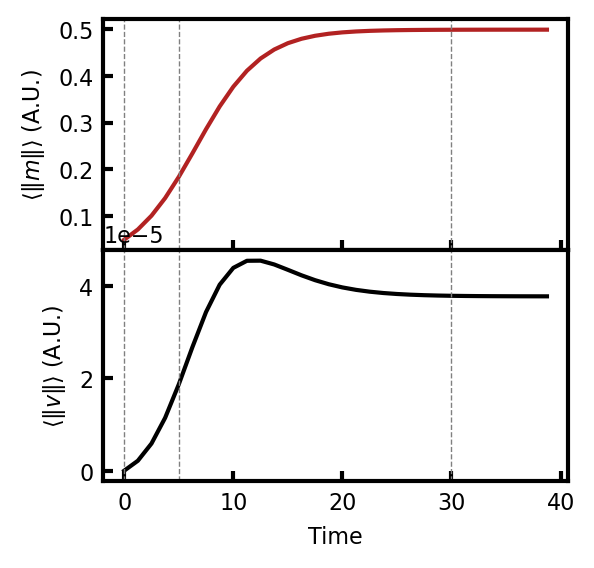

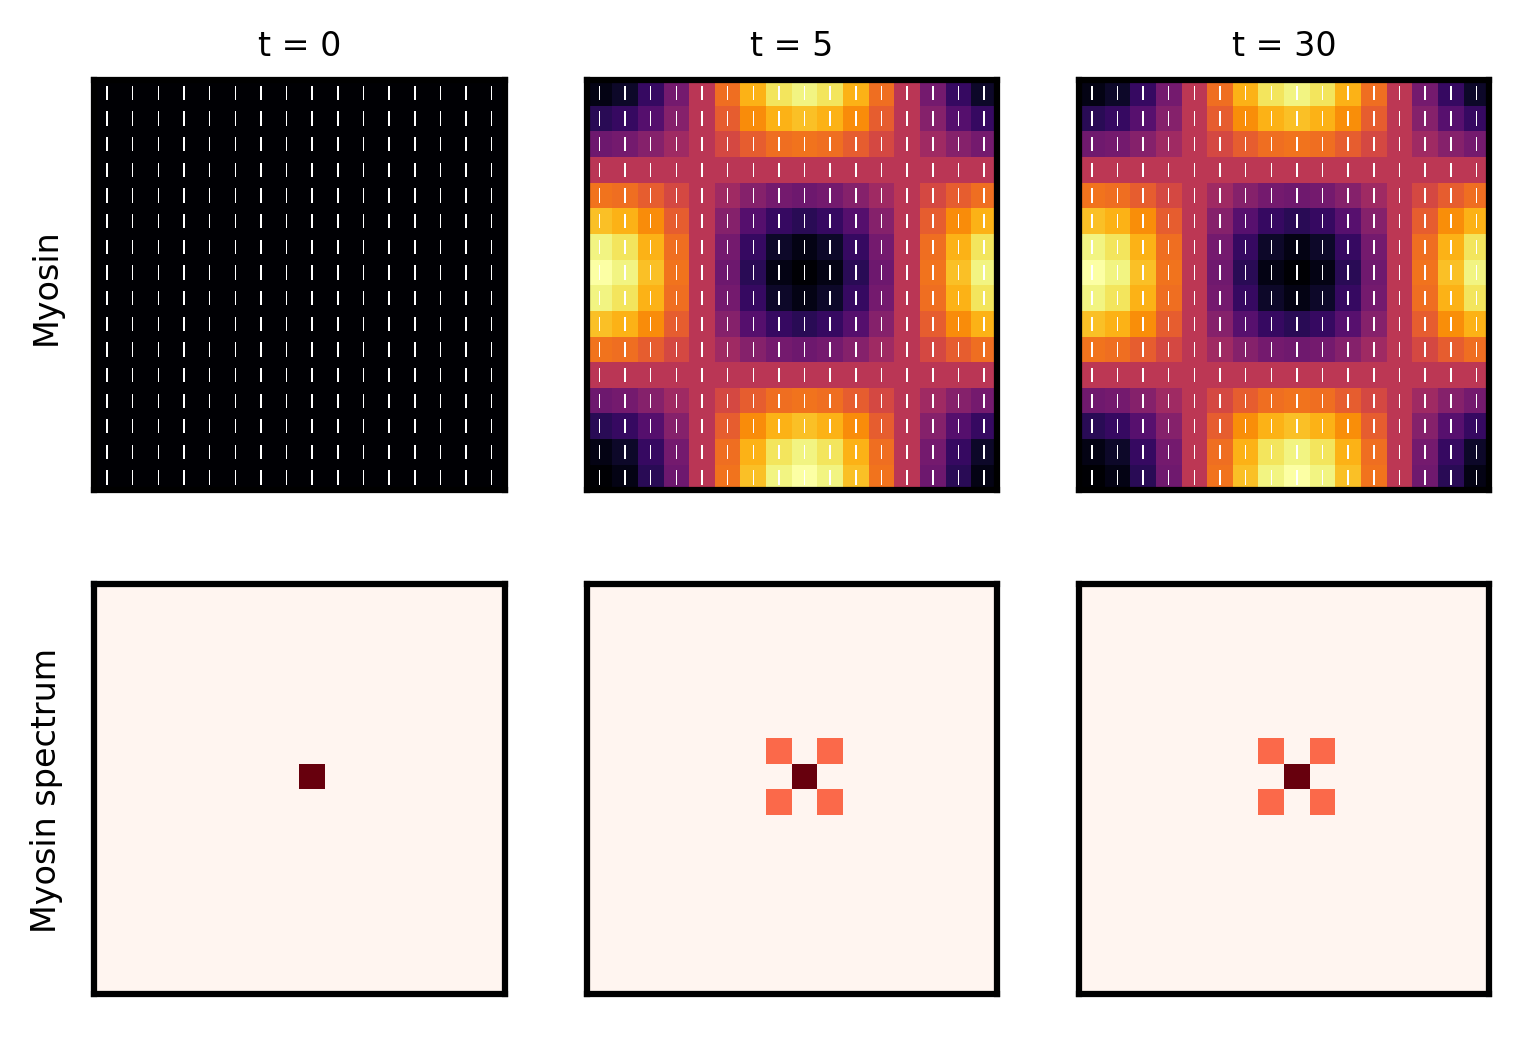

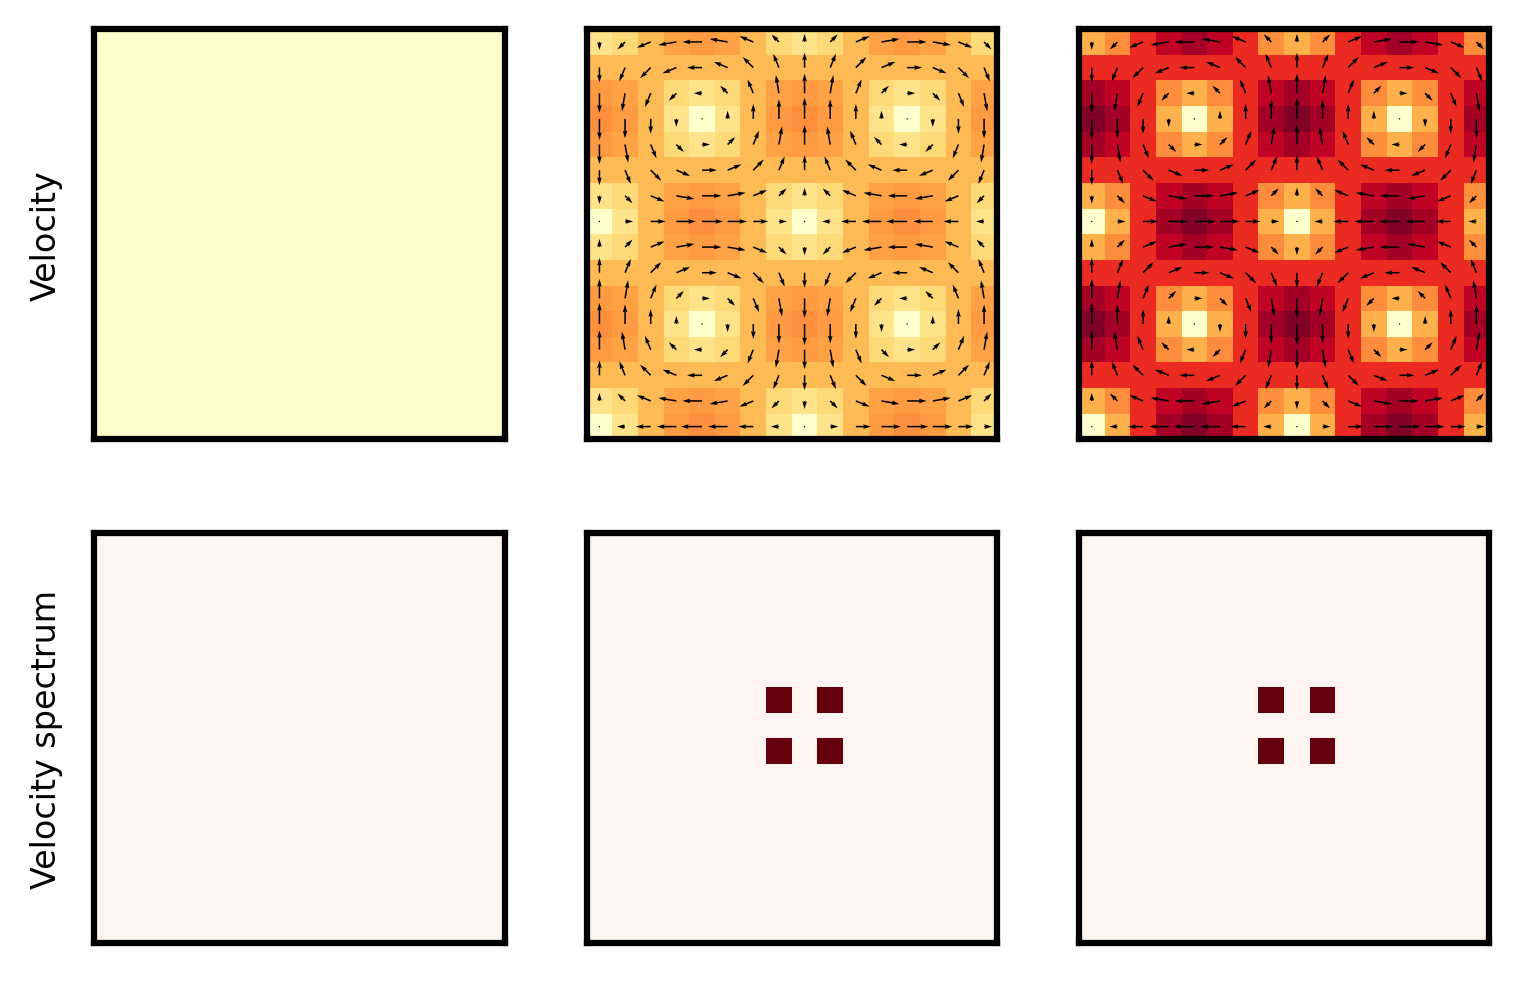

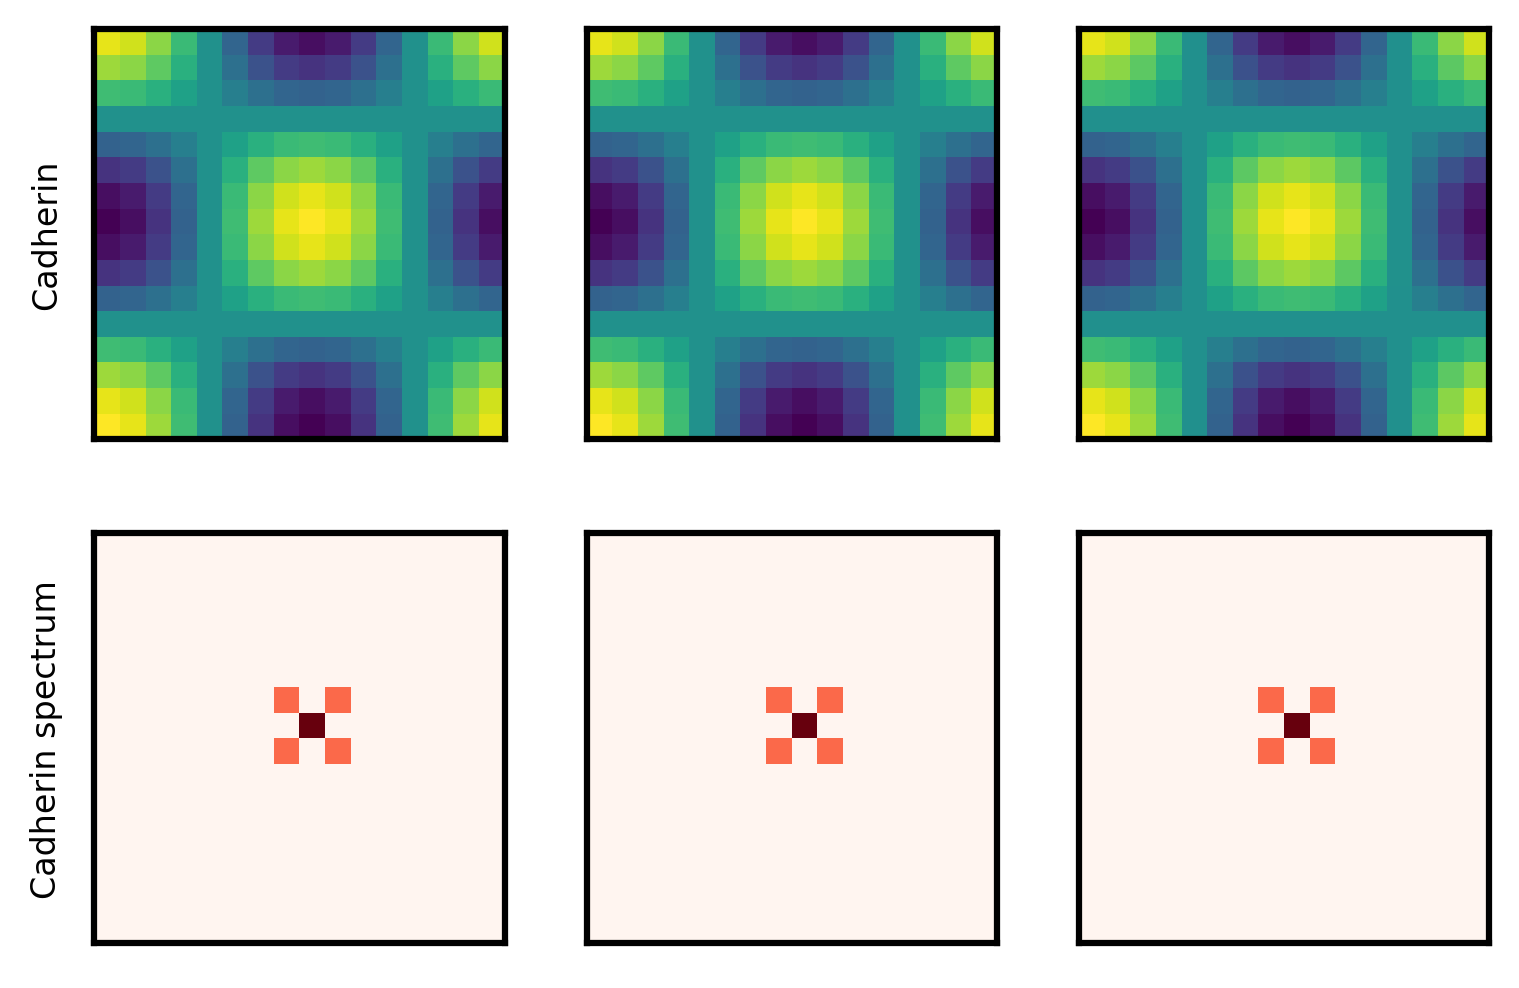

In [215]:
params = dict(
    Lx=1., Ly=1., Nx=16, Ny=16,
    am = 3, c0 = 1.2, c1 = 0.4,
    A = 1/3., B = -2/3., C = 0.,
    km = 0.6, kE = 0., conv=False,
    max_time=40, timestep=0.25, save_every=5,
)

simulate(params)
plot([0, 5, 30], show_cadherin=True)

## 2. Re-establish convective derivative and observe leading-order harmonic behavior

The convective derivative $\mathbf{v} \cdot \nabla m$ only has a $yy$ component - it corresponds to the advection of myosin density through the tissue. Its spectrum is
\begin{equation}
    \mathbf{v} \cdot \nabla m_{yy} (\mathbf{q}) = \frac{\alpha}{\mu} \left( \frac{A k c_1 }{4 B}\right)^2
    \begin{cases}
        -1 ,&\mathbf{q} = (0, \pm 2) \\
         1 ,&\mathbf{q} = (\pm 2, 0) \\
        0 ,& \text{otherwise}
    \end{cases}
\end{equation}

The co-rotation term $[\Omega, m]_{ij} = \Omega_{ik} m_{kj} - m_{ik} \Omega_{kj}$ is symmetric and has no diagonal component - co-rotation only re-orients the vector field rather than increasing density (trace). The spectrum of the vorticity is
\begin{equation}
    \Omega(\mathbf{q}) = -\frac{\alpha}{2\mu} \frac{A k c_1}{4 B}
    \begin{cases}
        \frac{q_x q_y}{q^2} ,&\mathbf{q} = (\pm 1, \pm 1) \\
        0 ,& \text{otherwise}
    \end{cases}
\end{equation}

which leads to the following spectrum for $[\Omega, m]$
\begin{equation}
    [\Omega, m]_{xy} (\mathbf{q}) = \frac{\alpha}{2\mu} \left(\frac{A k c_1}{4 B} \right)^2 \frac{q_x q_y}{q^2} 
    \begin{cases}
        4 \frac{1 - k c_0}{k c_1}
         ,&\mathbf{q} = (\pm 1, \pm 1) \\
        -1 ,&\mathbf{q} = (\pm 2, \pm 2) \\
        0 ,& \text{otherwise}
    \end{cases}
\end{equation}

Note that each of the above nonlinearities introduces contributions at higher wavenumbers that scale as $m(\mathbf{q})$. However, only the co-rotation term induces an effect at the leading-order harmonics, meaning that the orientational order of this fixed point is not stable. 

2023-06-21 12:55:23,226 __main__ 0/1 INFO :: Adding convective derivative term
2023-06-21 12:55:23,392 __main__ 0/1 INFO :: Starting main loop
2023-06-21 12:55:23,441 __main__ 0/1 INFO :: Iteration=1, Time=0.25
2023-06-21 12:55:23,849 __main__ 0/1 INFO :: Iteration=101, Time=25.25
2023-06-21 12:55:24,241 solvers 0/1 INFO :: Simulation stop time reached.


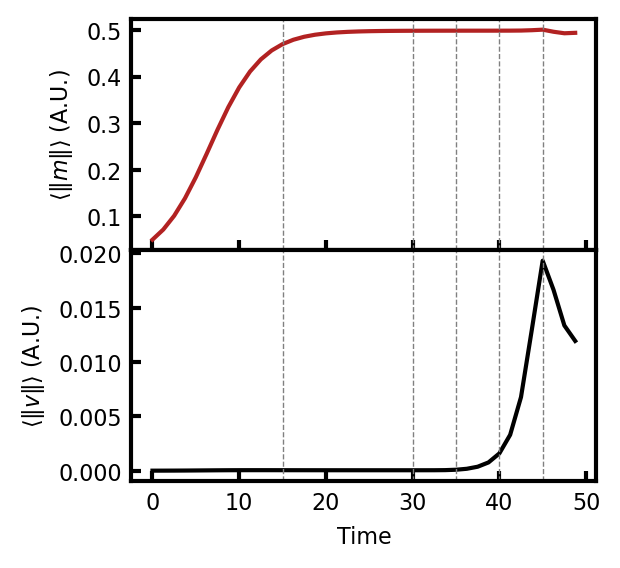

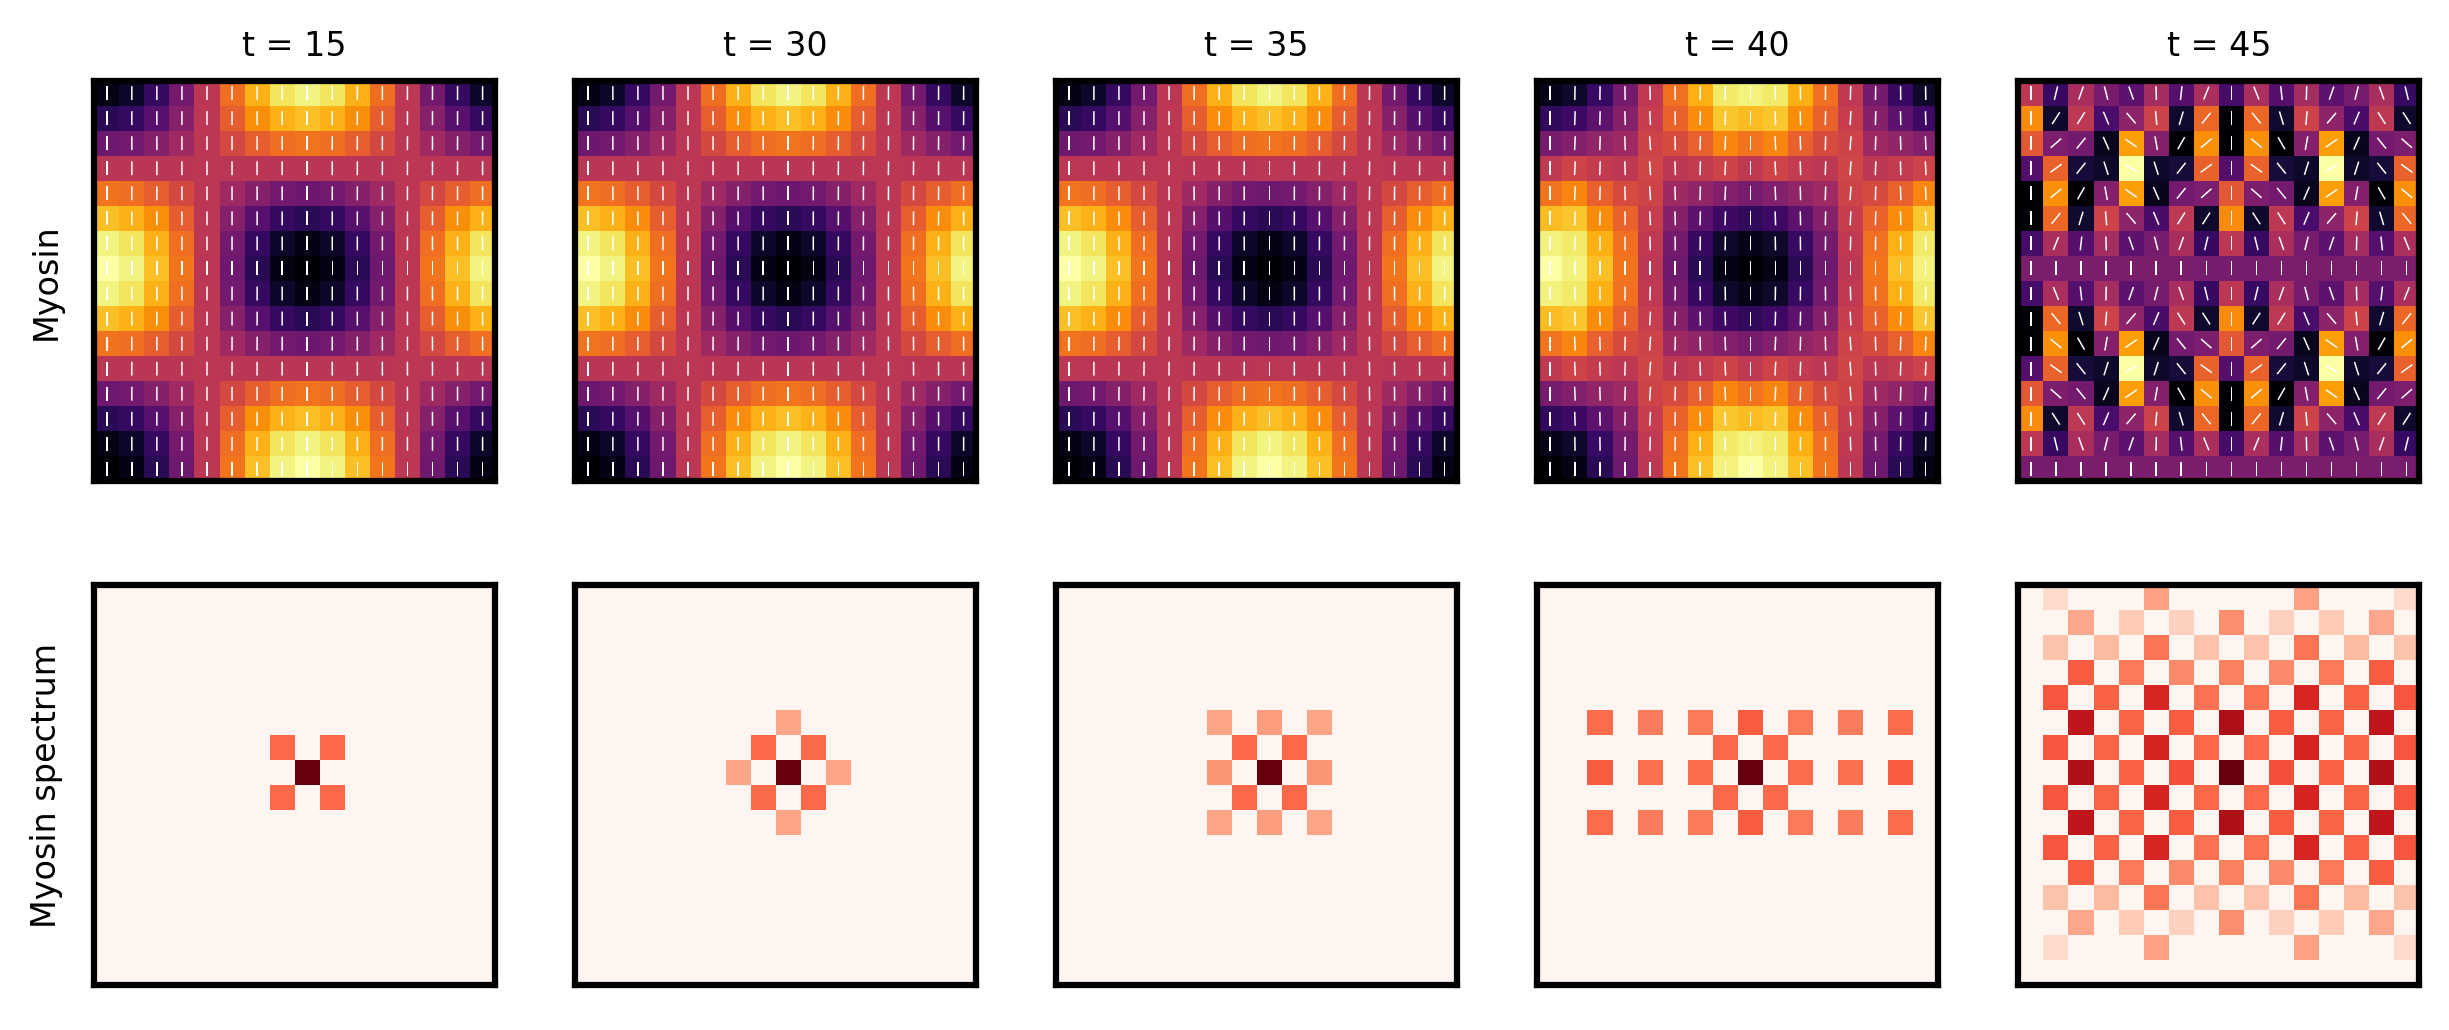

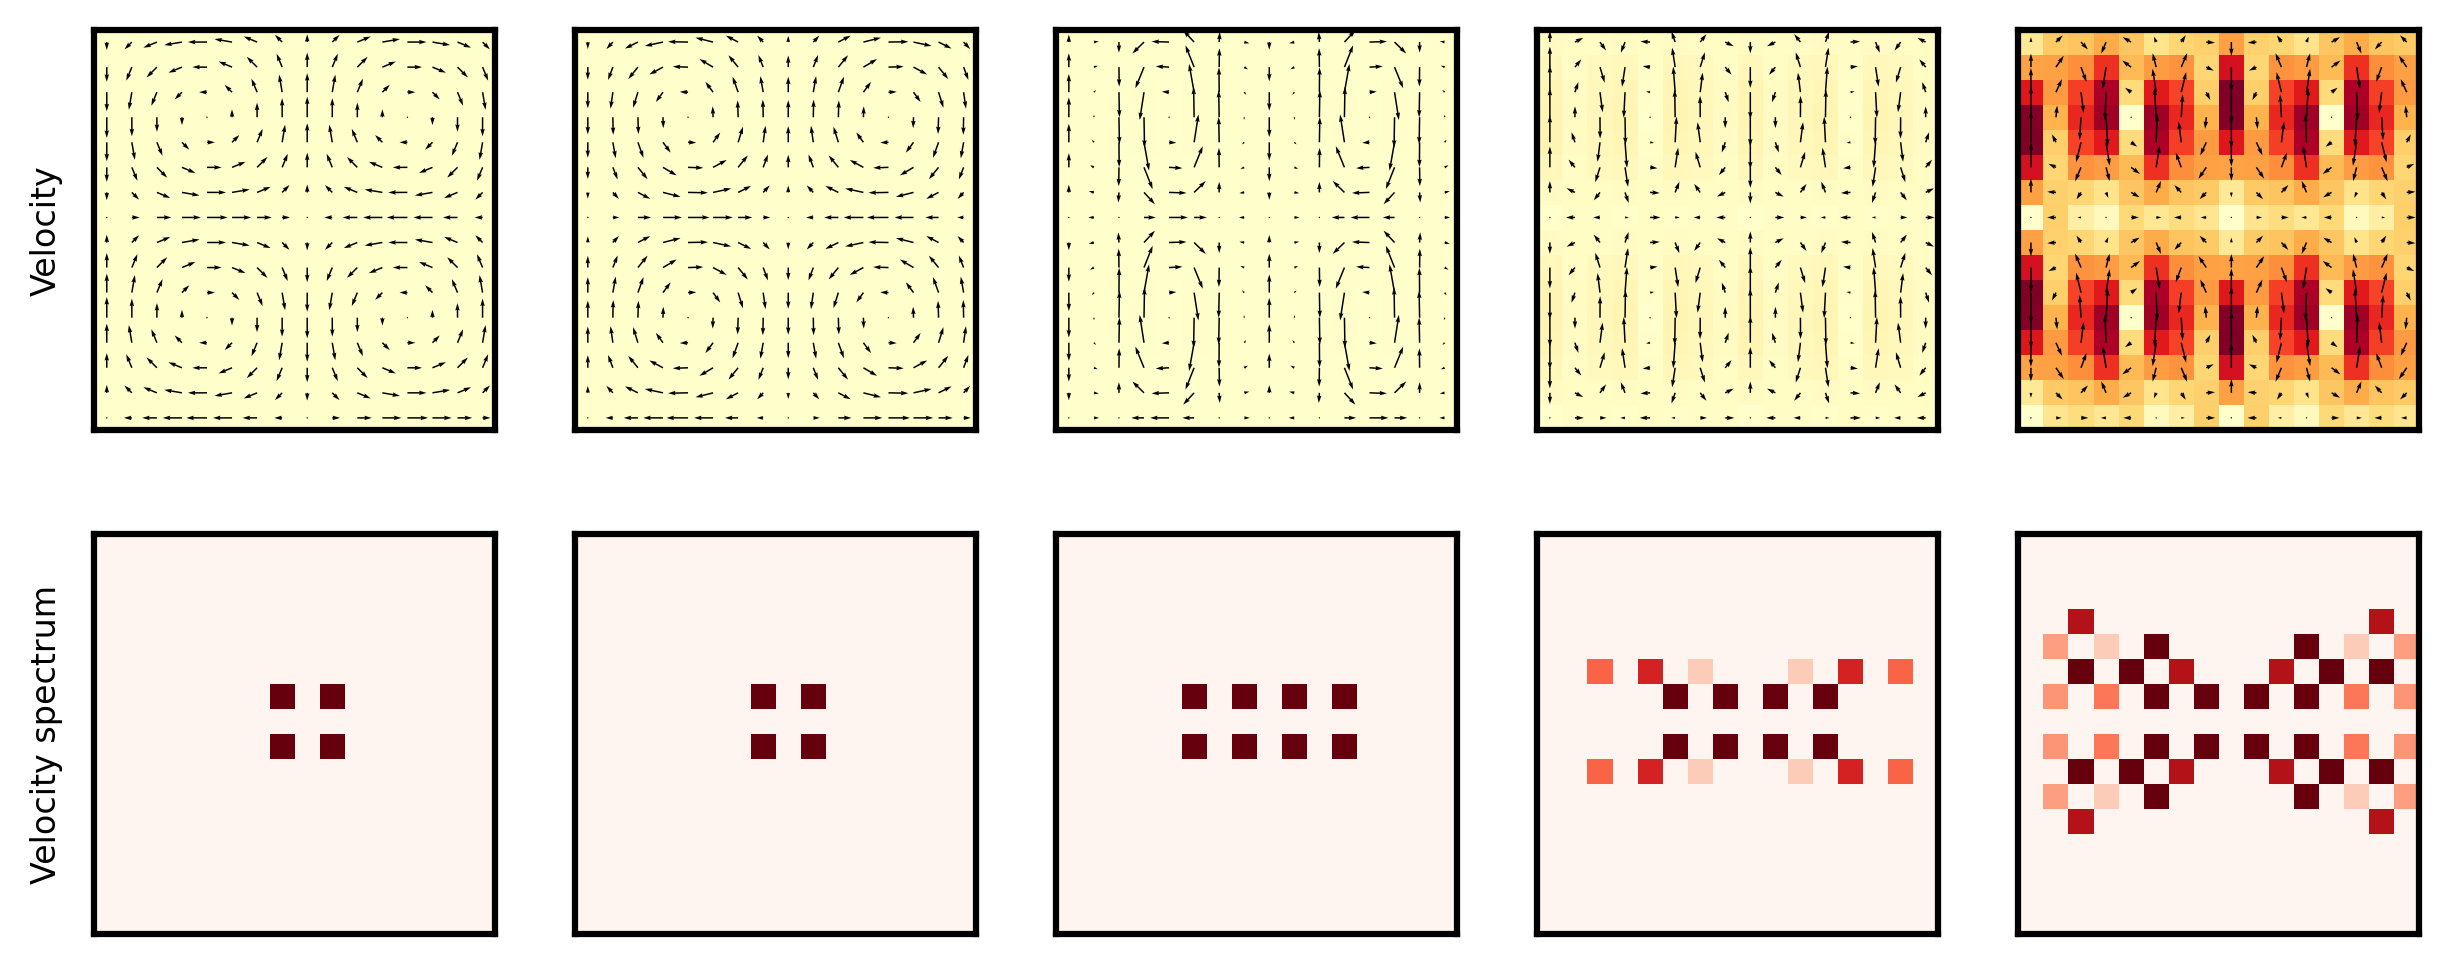

In [216]:
params = dict(
    Lx=1., Ly=1., Nx=16, Ny=16,
    am = 3., c0 = 1.2, c1 = 0.4,
    A = 1/3., B = -2/3., C = 0.,
    km = 0.6, kE = 0., conv=True,
    max_time=50, timestep=0.25, save_every=5,
)

simulate(params)
plot([15, 30, 35, 40, 45])

## 3. Eliminate leading-order effects of convective derivative

The co-rotation term destroys orientational order by introducing a $\mathbf{q} = (\pm 1, \pm 1)$ off-diagonal component to the left-hand side, and the convective derivative introduces higher-wavenumber modes to the myosin profile. Over time, these new components will propagate down the spectrum and introduce more high-frequency components which destroy order. We consider the effect of a mechanical feedback term to suppress this behavior.

First, note that for the strain rate tensor $E_{ij} = (\partial_i v_j + \partial_j v_i) / 2$, $E_{xy} = 0$ and $E_{xx} + E_{yy} = 0$ by incompressibility. We have that 
\begin{equation}
    E_{yy} = -E_{xx} = -\frac{\alpha}{2\mu}\frac{A k c_1}{4 \mu B} \begin{cases}
         \frac{q_y^2}{q^2},& \mathbf{q} = (\pm 1, \pm 1) \\
        0 ,& \text{otherwise}
    \end{cases}
\end{equation}

2023-06-21 12:55:30,409 __main__ 0/1 INFO :: Adding convective derivative term
2023-06-21 12:55:30,557 __main__ 0/1 INFO :: Starting main loop
2023-06-21 12:55:30,612 __main__ 0/1 INFO :: Iteration=1, Time=0.25
2023-06-21 12:55:31,097 __main__ 0/1 INFO :: Iteration=101, Time=25.25
2023-06-21 12:55:31,577 __main__ 0/1 INFO :: Iteration=201, Time=50.25
2023-06-21 12:55:32,055 __main__ 0/1 INFO :: Iteration=301, Time=75.25
2023-06-21 12:55:32,530 __main__ 0/1 INFO :: Iteration=401, Time=100.25
2023-06-21 12:55:33,003 __main__ 0/1 INFO :: Iteration=501, Time=125.25
2023-06-21 12:55:33,479 __main__ 0/1 INFO :: Iteration=601, Time=150.25
2023-06-21 12:55:33,952 __main__ 0/1 INFO :: Iteration=701, Time=175.25
2023-06-21 12:55:34,415 solvers 0/1 INFO :: Simulation stop time reached.


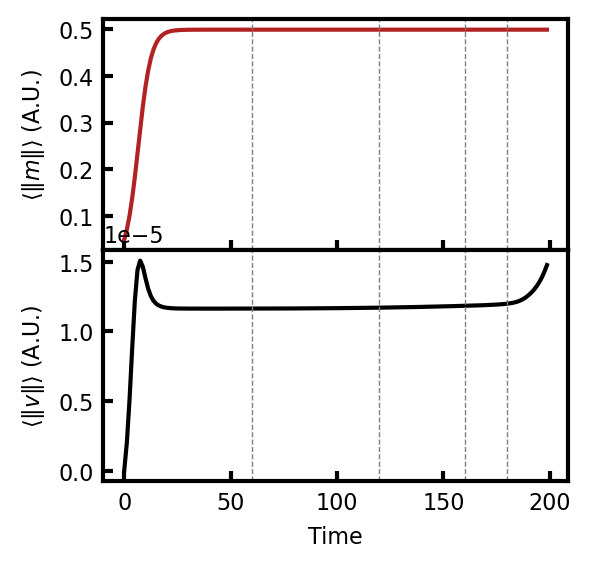

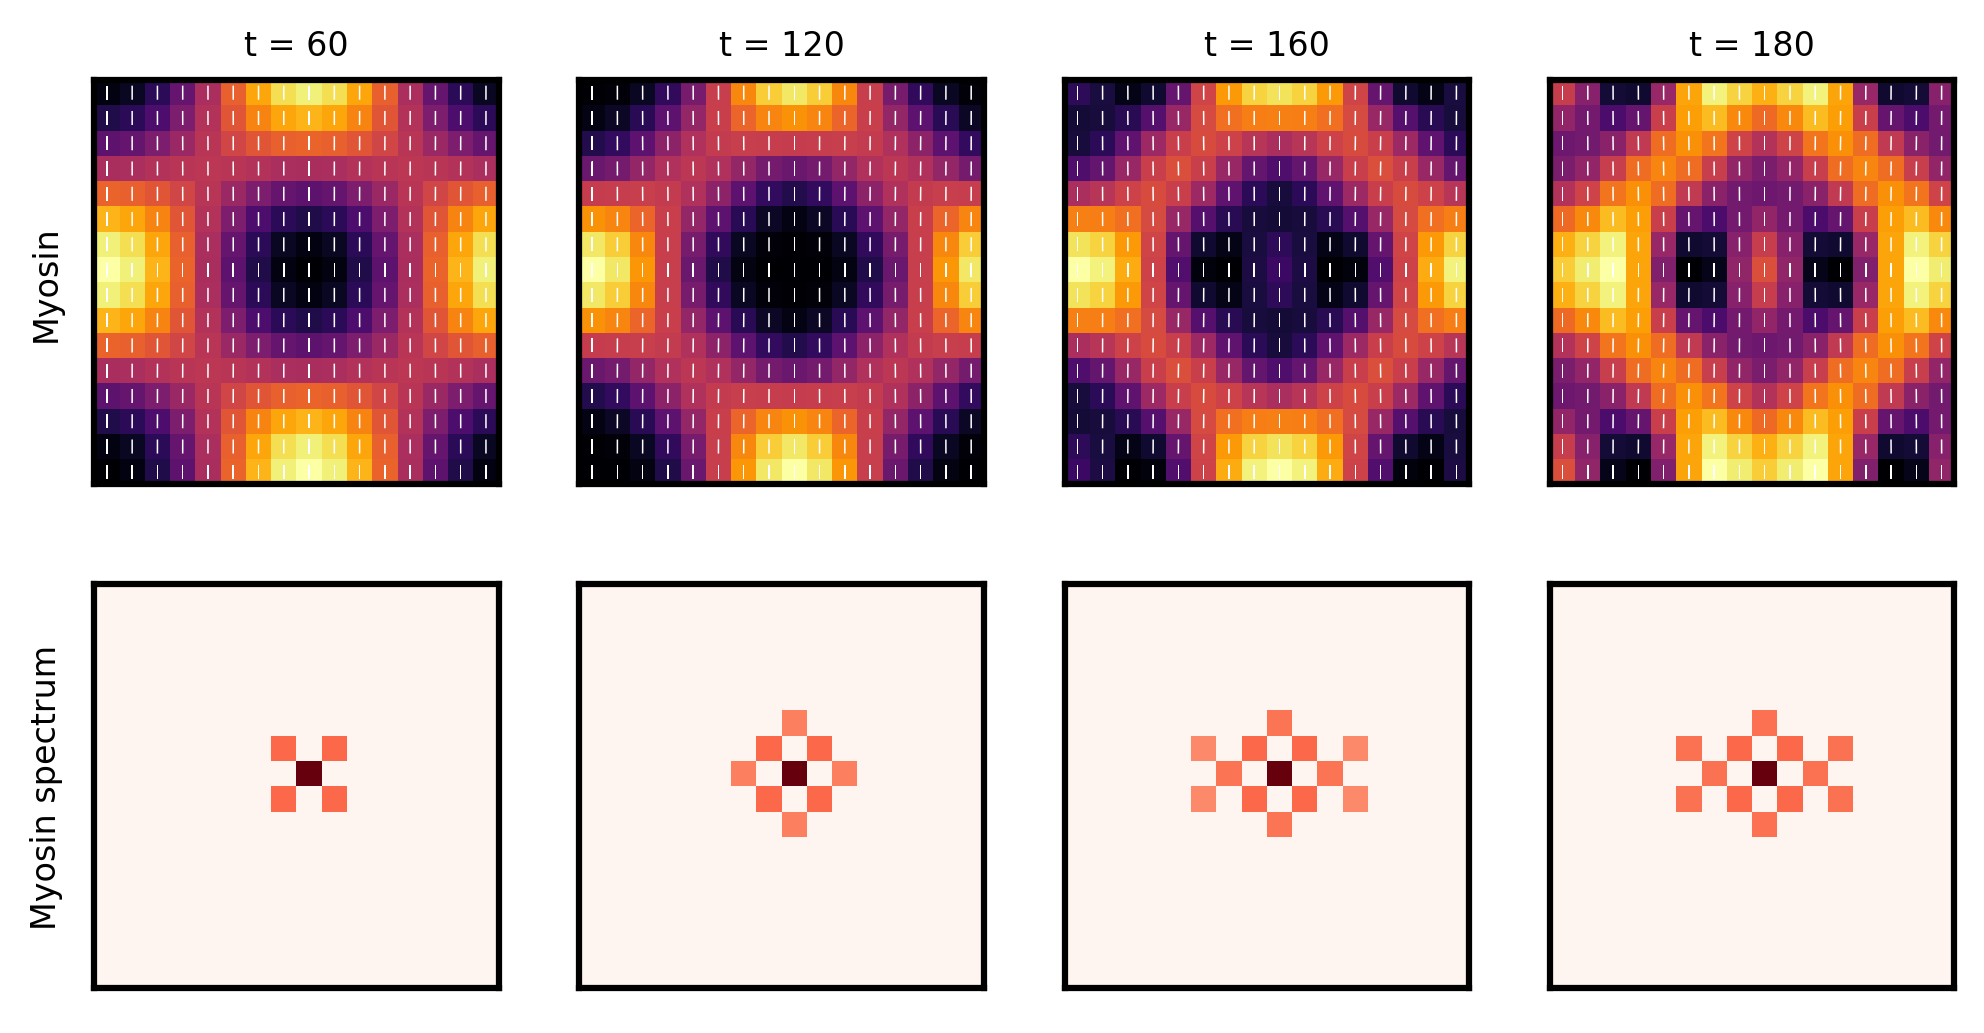

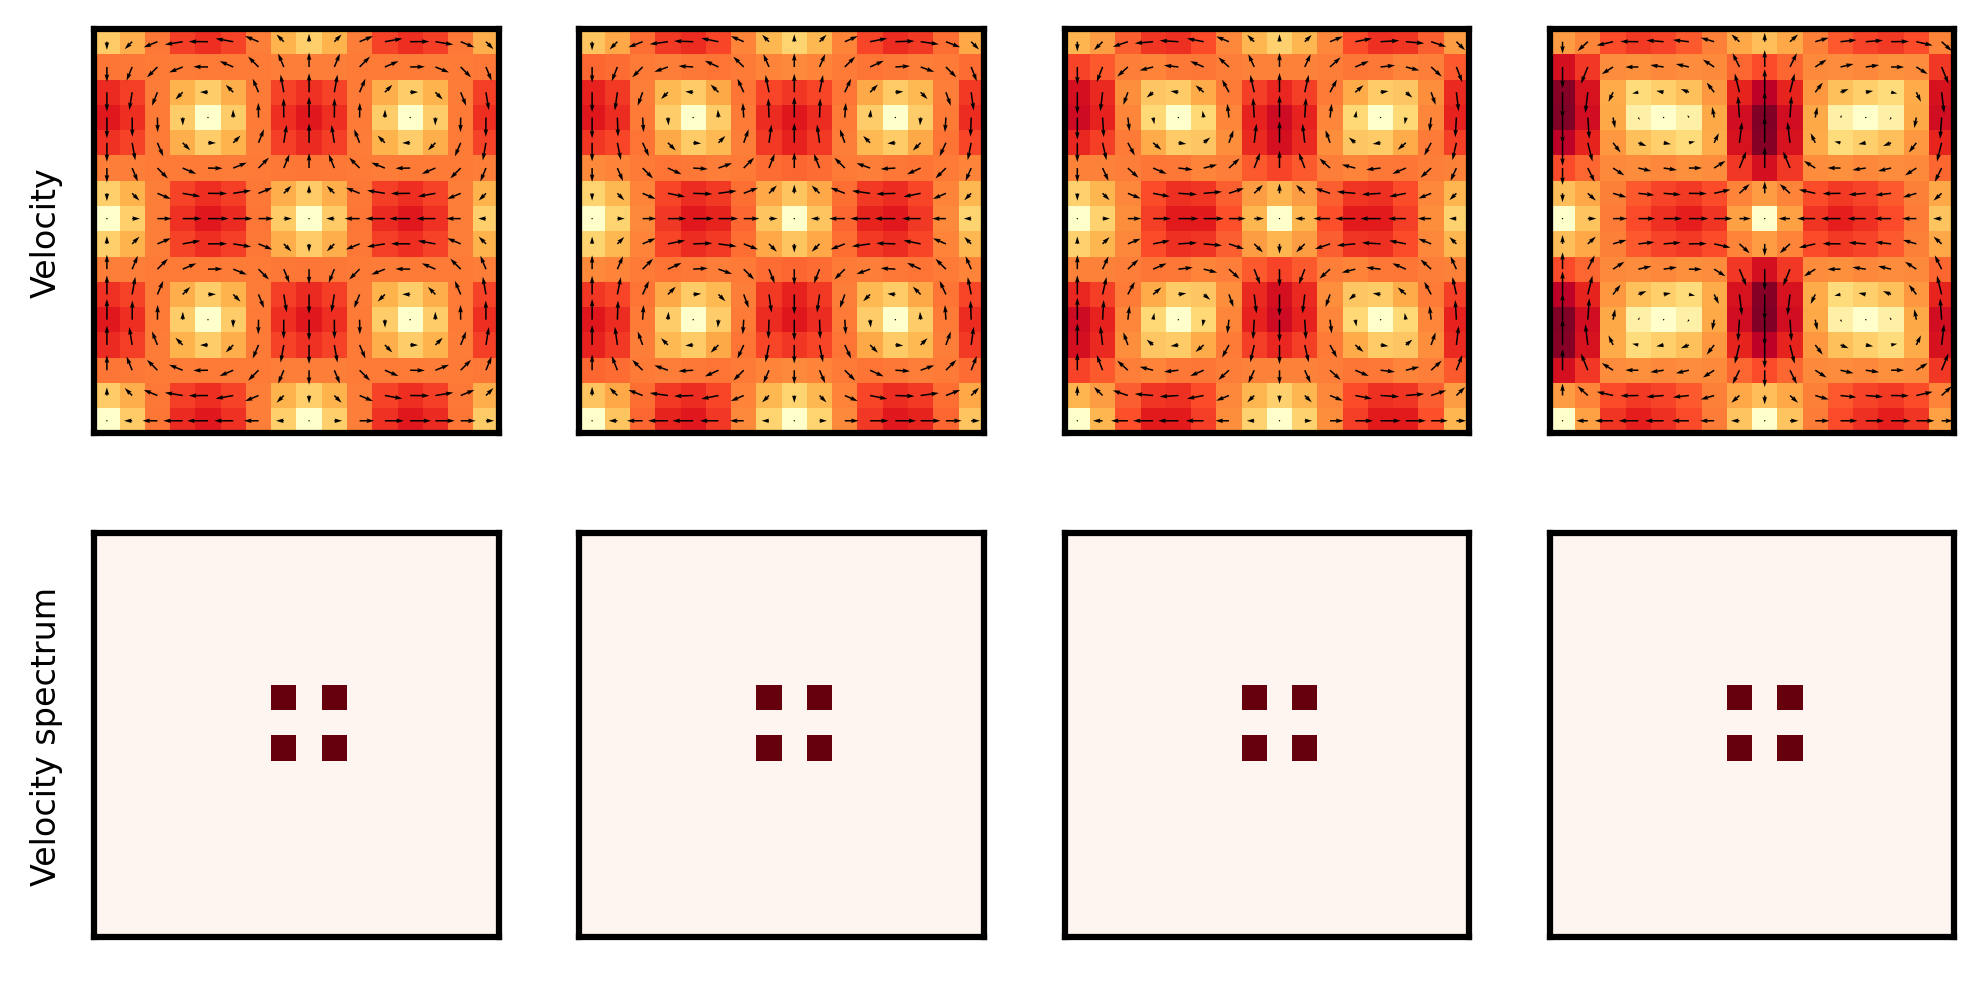

In [217]:
params = dict(
    Lx=1., Ly=1., Nx=16, Ny=16,
    am = 3., c0 = 1.2, c1 = 0.4,
    A = 1/3., B = -2/3., C = 1,
    km = 0.6, kE = 0.6, conv=True,
    max_time=200, timestep=0.25, save_every=5,
)

simulate(params)
plot([60, 120, 160, 180])

2023-06-21 12:55:38,091 __main__ 0/1 INFO :: Adding convective derivative term
2023-06-21 12:55:38,240 __main__ 0/1 INFO :: Starting main loop
2023-06-21 12:55:38,292 __main__ 0/1 INFO :: Iteration=1, Time=0.25
2023-06-21 12:55:38,754 __main__ 0/1 INFO :: Iteration=101, Time=25.25
2023-06-21 12:55:39,211 __main__ 0/1 INFO :: Iteration=201, Time=50.25
2023-06-21 12:55:40,125 __main__ 0/1 INFO :: Iteration=301, Time=75.25
2023-06-21 12:55:40,579 __main__ 0/1 INFO :: Iteration=401, Time=100.25
2023-06-21 12:55:41,033 __main__ 0/1 INFO :: Iteration=501, Time=125.25
2023-06-21 12:55:41,487 __main__ 0/1 INFO :: Iteration=601, Time=150.25
2023-06-21 12:55:41,940 __main__ 0/1 INFO :: Iteration=701, Time=175.25
2023-06-21 12:55:42,383 solvers 0/1 INFO :: Simulation stop time reached.


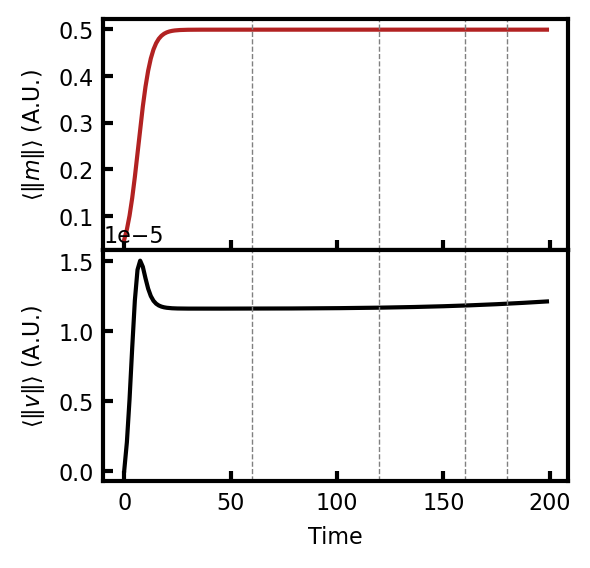

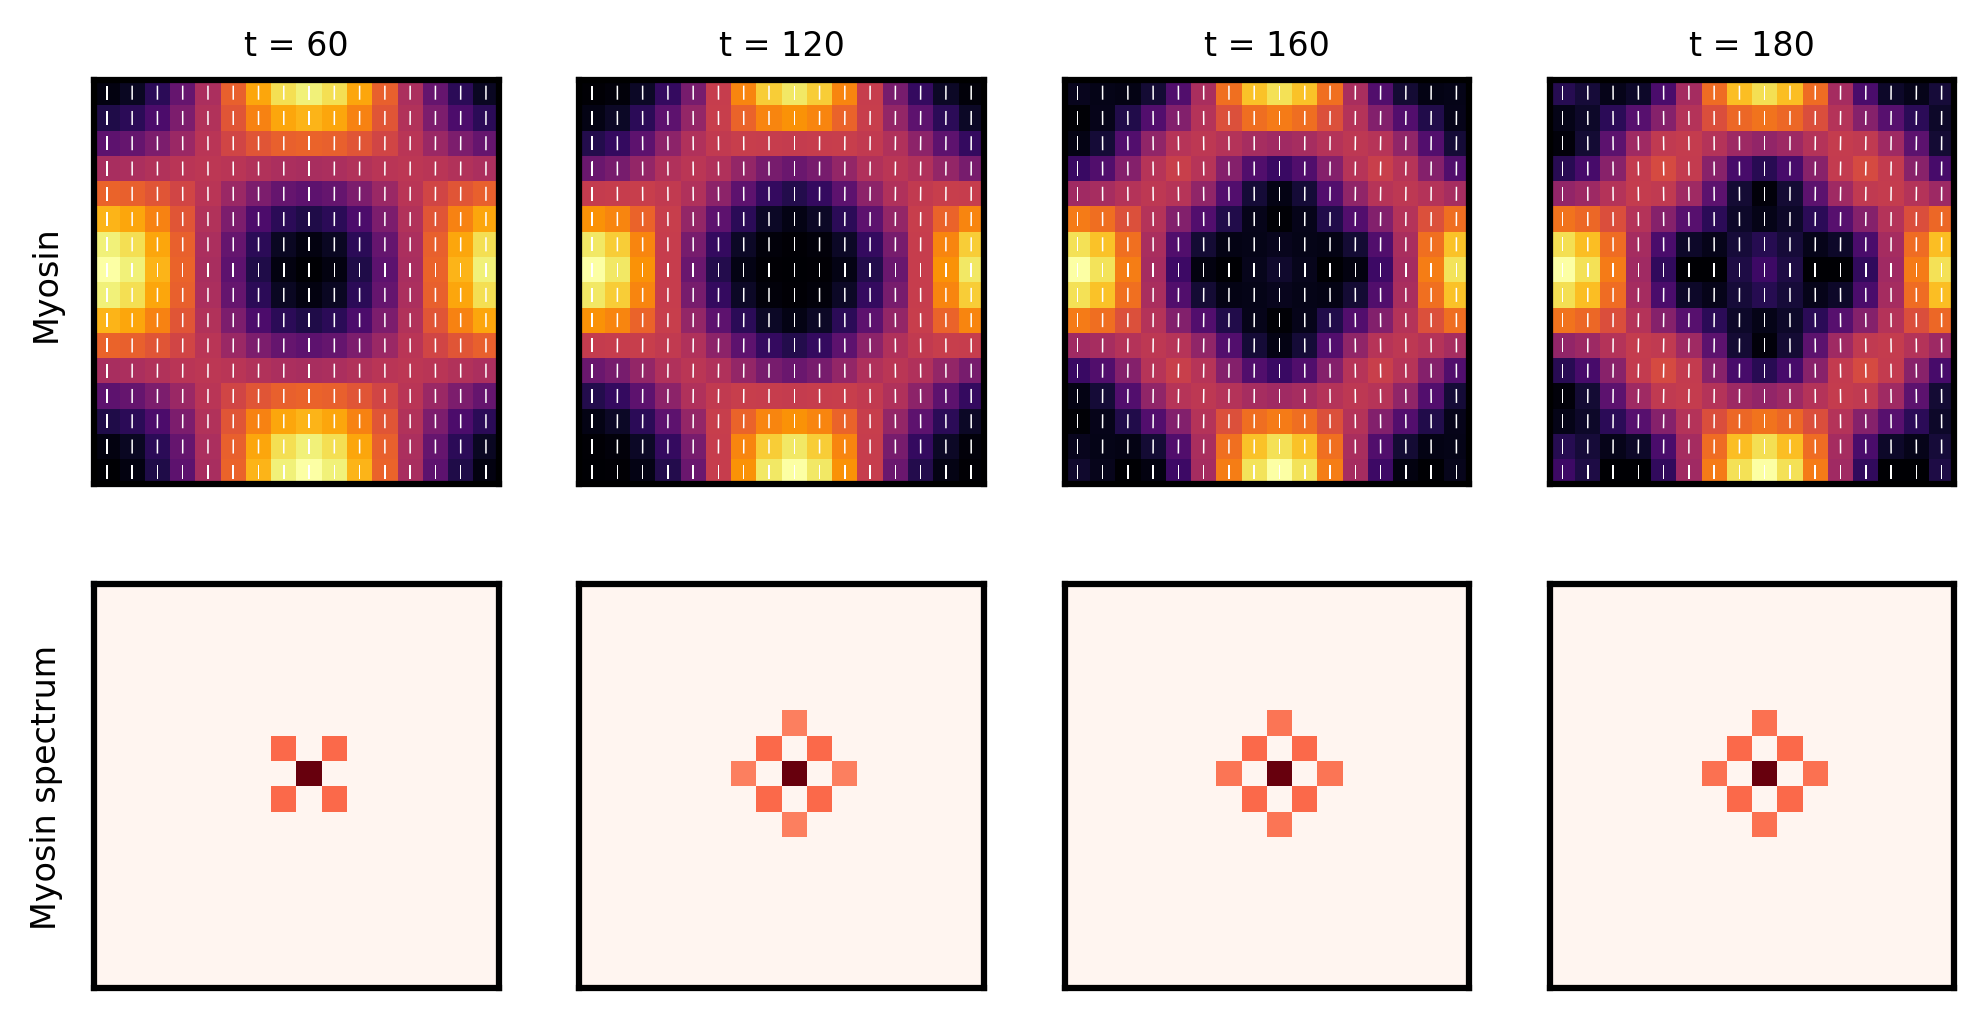

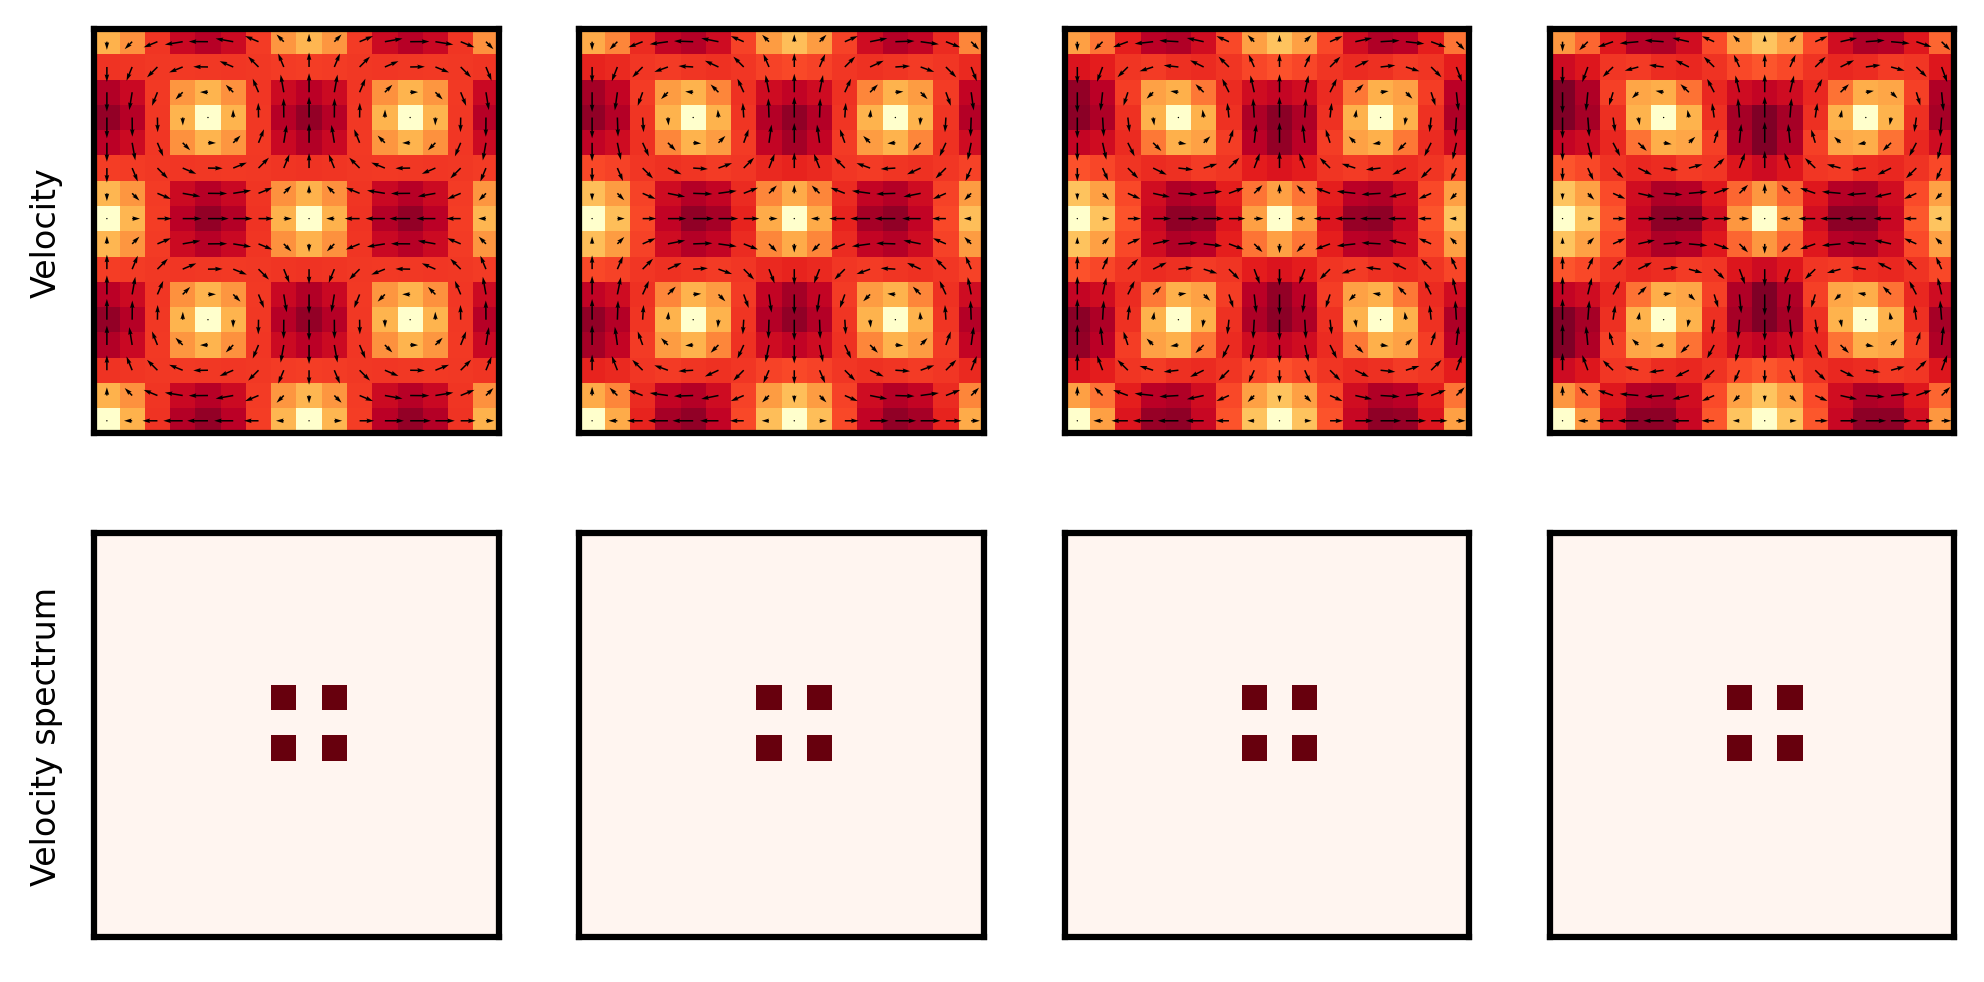

In [218]:
params = dict(
    Lx=1., Ly=1., Nx=16, Ny=16,
    am = 3., c0 = 1.2, c1 = 0.4,
    A = 1/3., B = -2/3., C = 1,
    km = 0.6, kE = 0.0, conv=True,
    max_time=200, timestep=0.25, save_every=5,
)

simulate(params)
plot([60, 120, 160, 180])

2023-06-21 12:55:46,518 __main__ 0/1 INFO :: Adding convective derivative term
2023-06-21 12:55:46,665 __main__ 0/1 INFO :: Starting main loop
2023-06-21 12:55:46,718 __main__ 0/1 INFO :: Iteration=1, Time=0.25
2023-06-21 12:55:47,194 __main__ 0/1 INFO :: Iteration=101, Time=25.25
2023-06-21 12:55:47,666 __main__ 0/1 INFO :: Iteration=201, Time=50.25
2023-06-21 12:55:48,137 __main__ 0/1 INFO :: Iteration=301, Time=75.25
2023-06-21 12:55:48,606 __main__ 0/1 INFO :: Iteration=401, Time=100.25
2023-06-21 12:55:49,075 __main__ 0/1 INFO :: Iteration=501, Time=125.25
2023-06-21 12:55:49,692 __main__ 0/1 INFO :: Iteration=601, Time=150.25
2023-06-21 12:55:50,160 __main__ 0/1 INFO :: Iteration=701, Time=175.25
2023-06-21 12:55:50,618 solvers 0/1 INFO :: Simulation stop time reached.


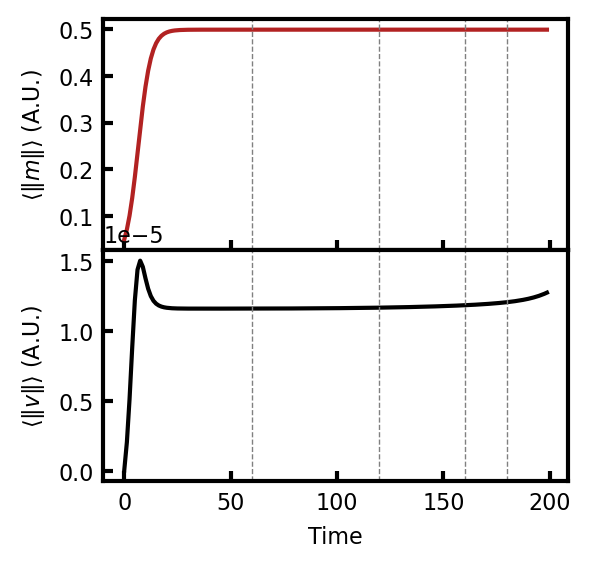

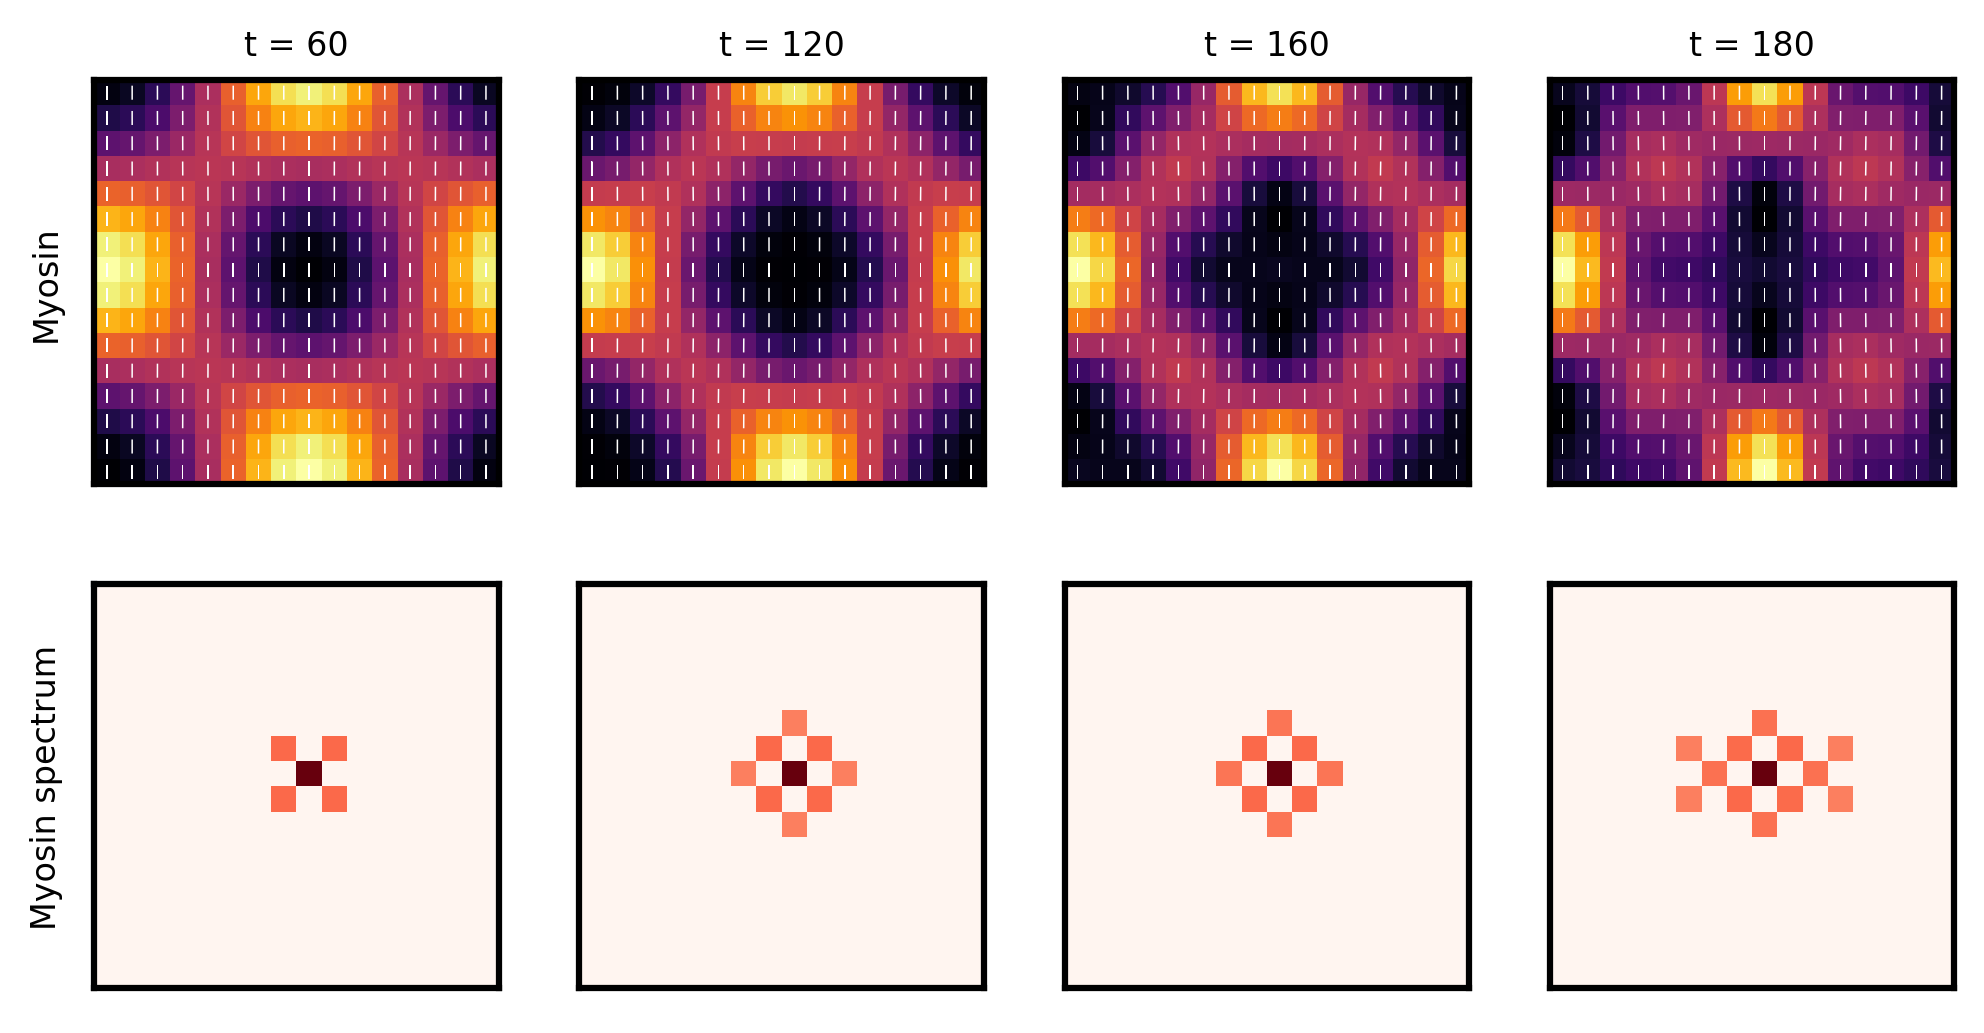

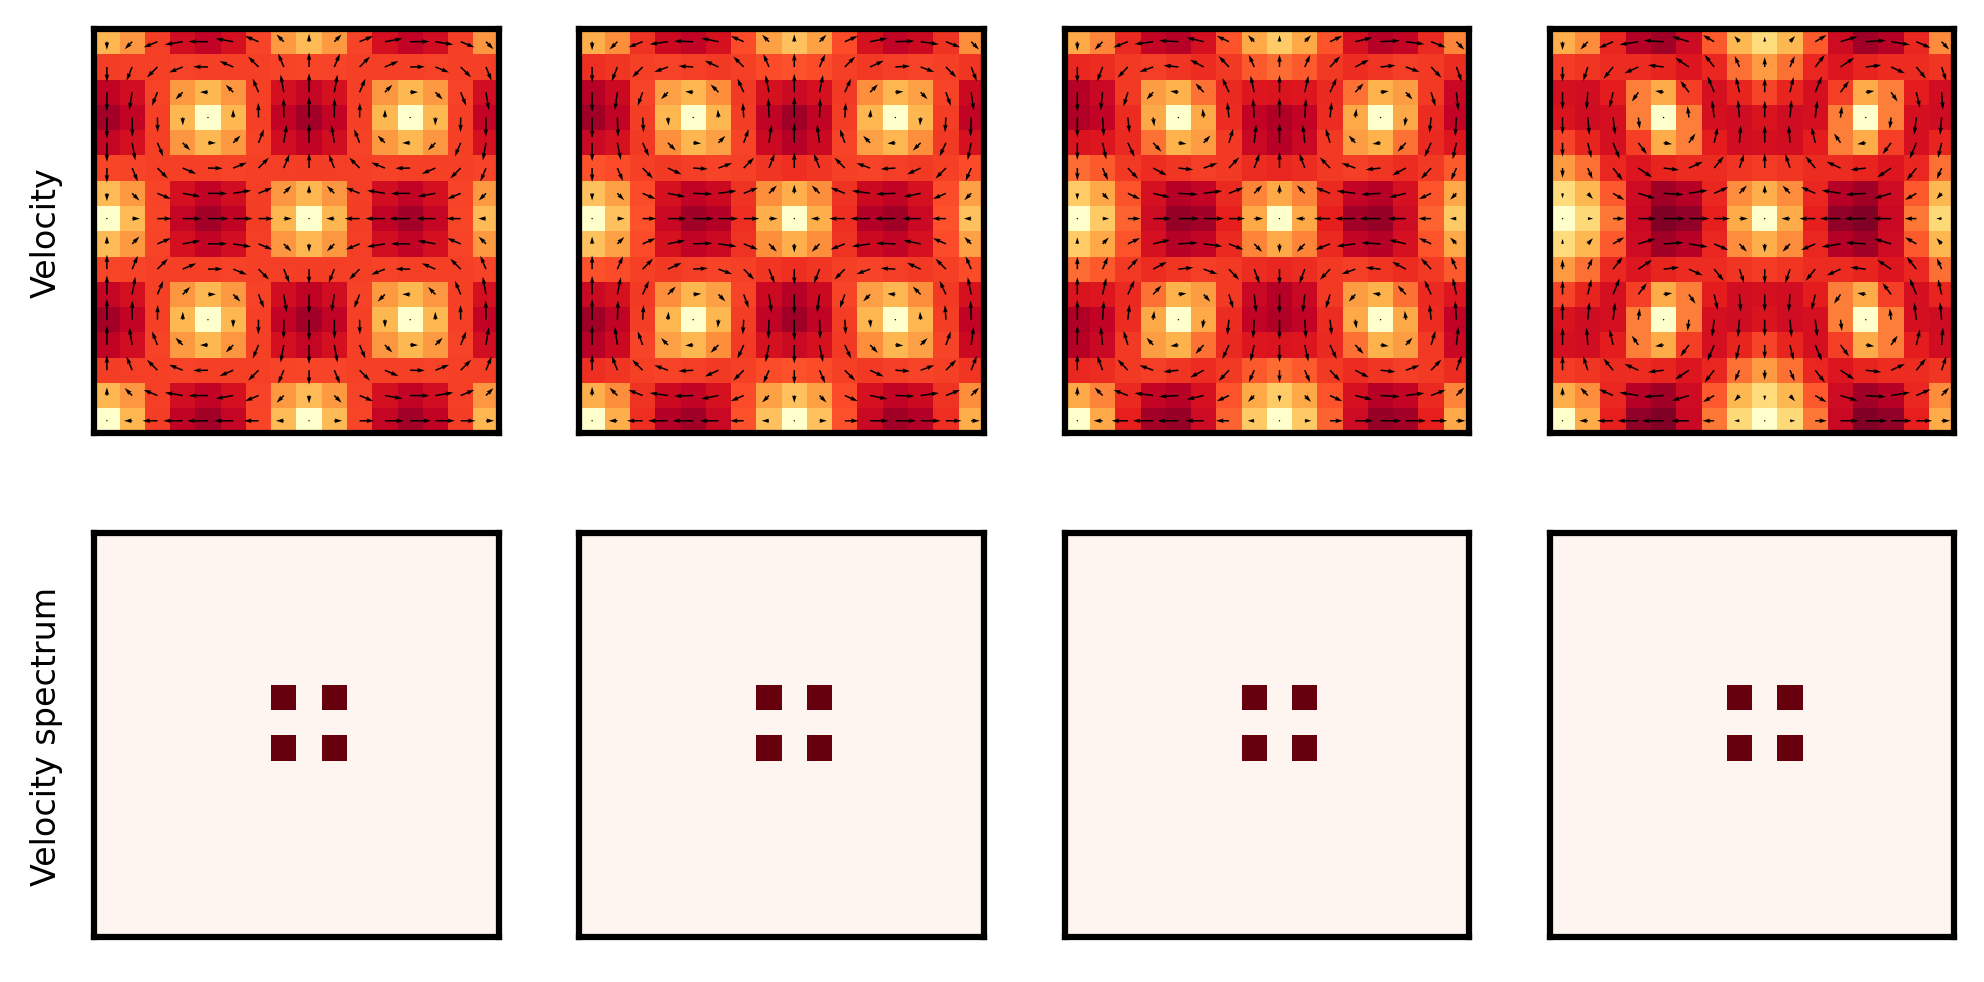

In [219]:
params = dict(
    Lx=1., Ly=1., Nx=16, Ny=16,
    am = 3., c0 = 1.2, c1 = 0.4,
    A = 1/3., B = -2/3., C = 1,
    km = 0.6, kE = -0.6, conv=True,
    max_time=200, timestep=0.25, save_every=5,
)

simulate(params)
plot([60, 120, 160, 180])